## Библиотеки 

In [1]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)


import warnings
warnings.filterwarnings("ignore")

## Функции

In [59]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def apks(actual, predicted, k=10):
    return [apk(a, p, k) for a, p in zip(actual, predicted)]
def mapk(actual, predicted, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

## Получение данных

In [3]:
df_train = pd.read_csv('data/df_train.csv', sep=';')
df_test = pd.read_csv('data/df_test.csv', sep=';')

In [4]:
df_train['Data'] = df_train.Data.apply(lambda s: list(map(int, s.split(','))))
df_train['Target'] = df_train.Target.apply(lambda s: list(map(int, s.split(','))))
df_test['Data'] = df_test.Data.apply(lambda s: list(map(int, s.split(','))))

In [5]:
df_train.head()

,Id,Data,Target
0,0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481..."
1,1,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...","[4814, 6011, 4814, 6011, 4814, 4814, 6011, 481..."
2,2,"[8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...","[6011, 6011, 6010, 4829, 4829, 6010, 6011, 601..."
3,3,"[4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...","[6011, 6011, 6010, 6011, 6011, 4814, 4814, 601..."
4,4,"[4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...","[5499, 6011, 4814, 4829, 5200, 5411, 5499, 591..."


## EDA

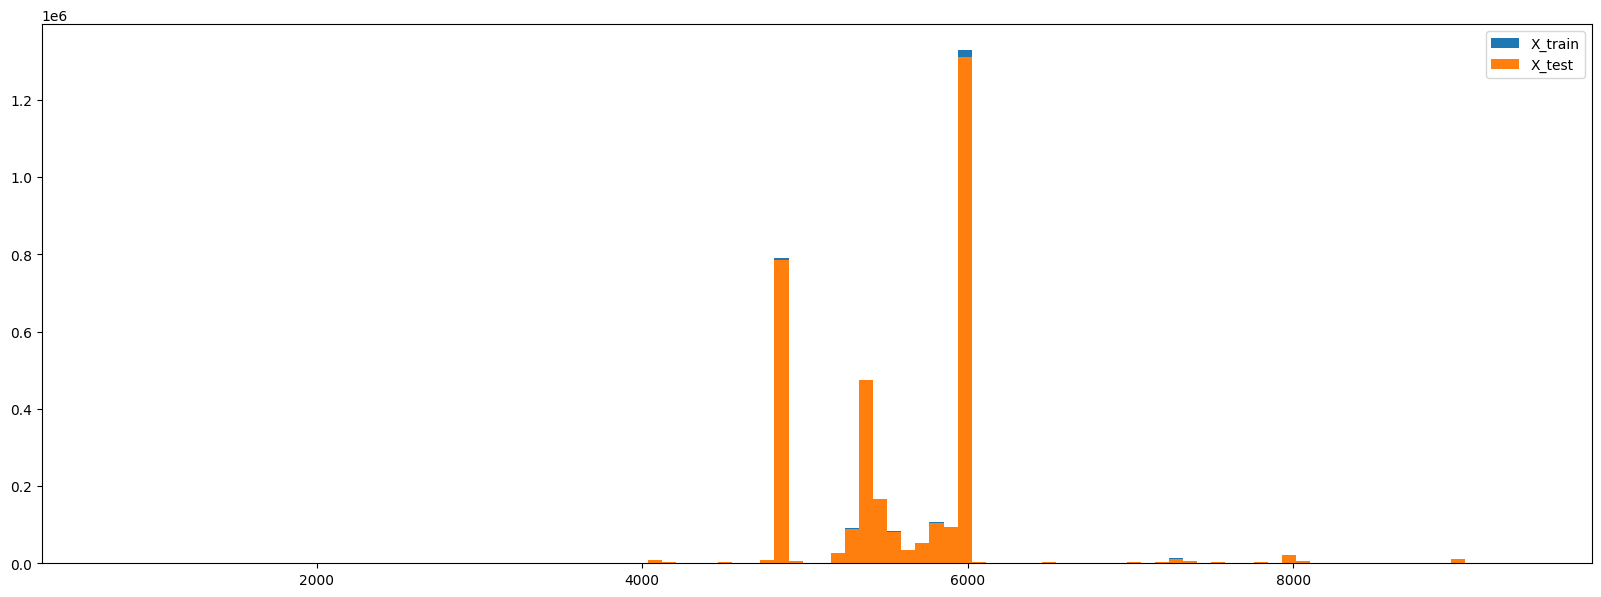

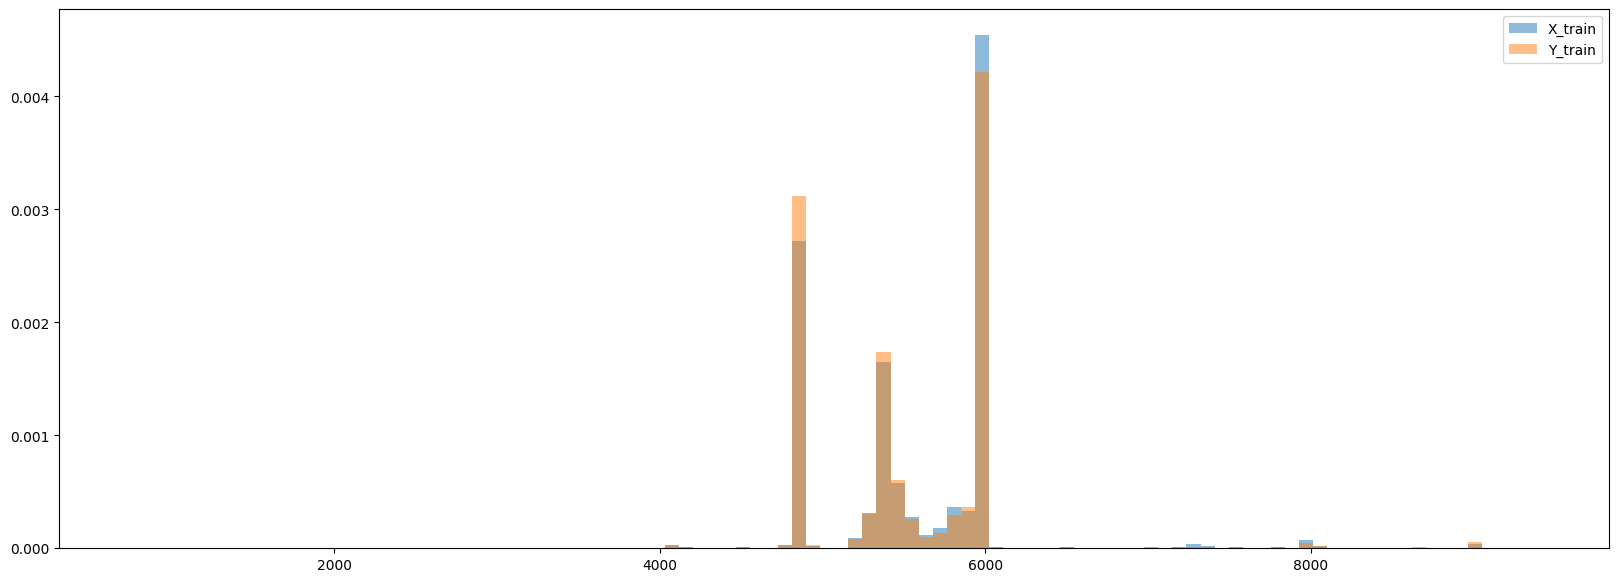

In [6]:
plt.hist(df_test['Data'].explode(), bins=100)
plt.hist(df_train['Data'].explode(), bins=100)
plt.legend(["X_train","X_test"])
plt.show()
# plt.hist(df_test.Target.explode(), bins=100)
plt.hist(df_train.Data.explode(), bins=100, density=1, alpha=0.5)
plt.hist(df_train.Target.explode(), bins=100, density=1, alpha=0.5)
plt.legend(["X_train","Y_train"])

plt.show()

Распределения одинаковые в Х и У. В тесте и трейне

In [7]:
df_train.Data.explode().nunique()

184

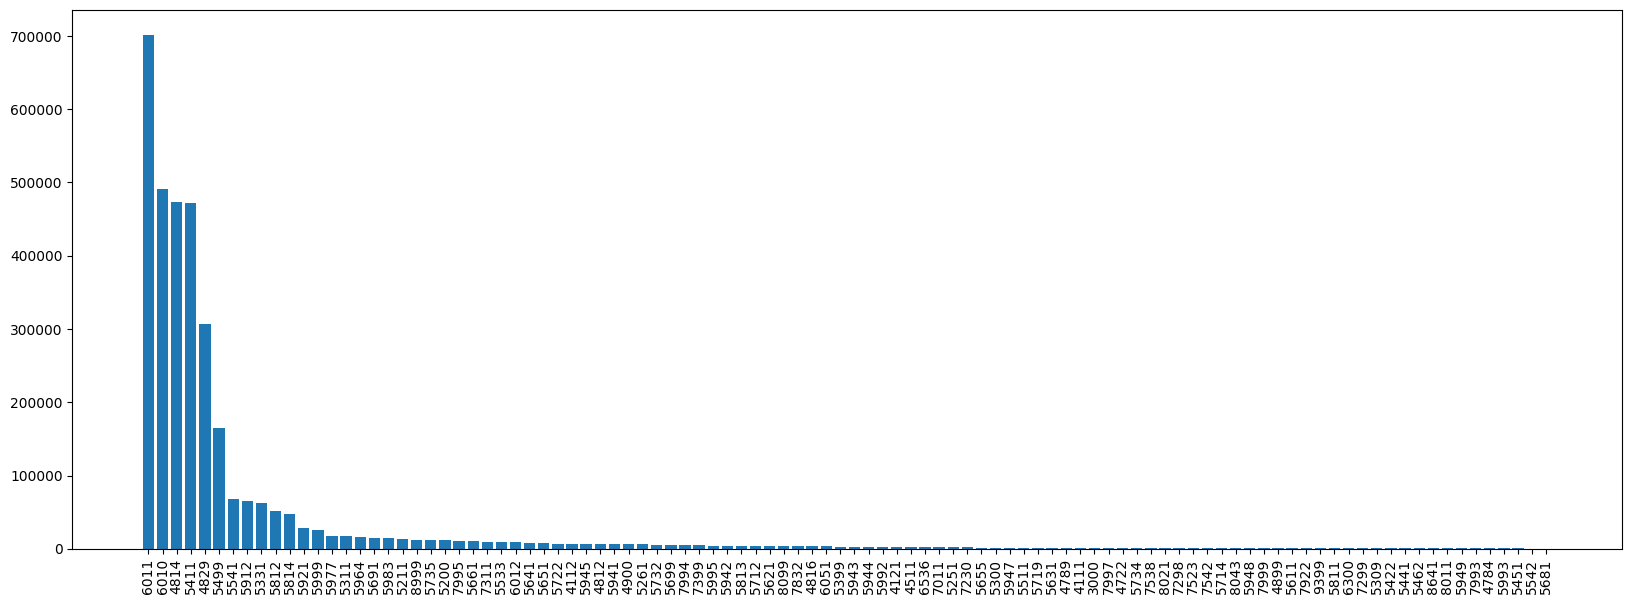

In [8]:
vc = df_train.Data.explode().value_counts()[:100]
plt.bar(list(map(str, vc.index)), vc)
plt.xticks(rotation=90)
plt.show()

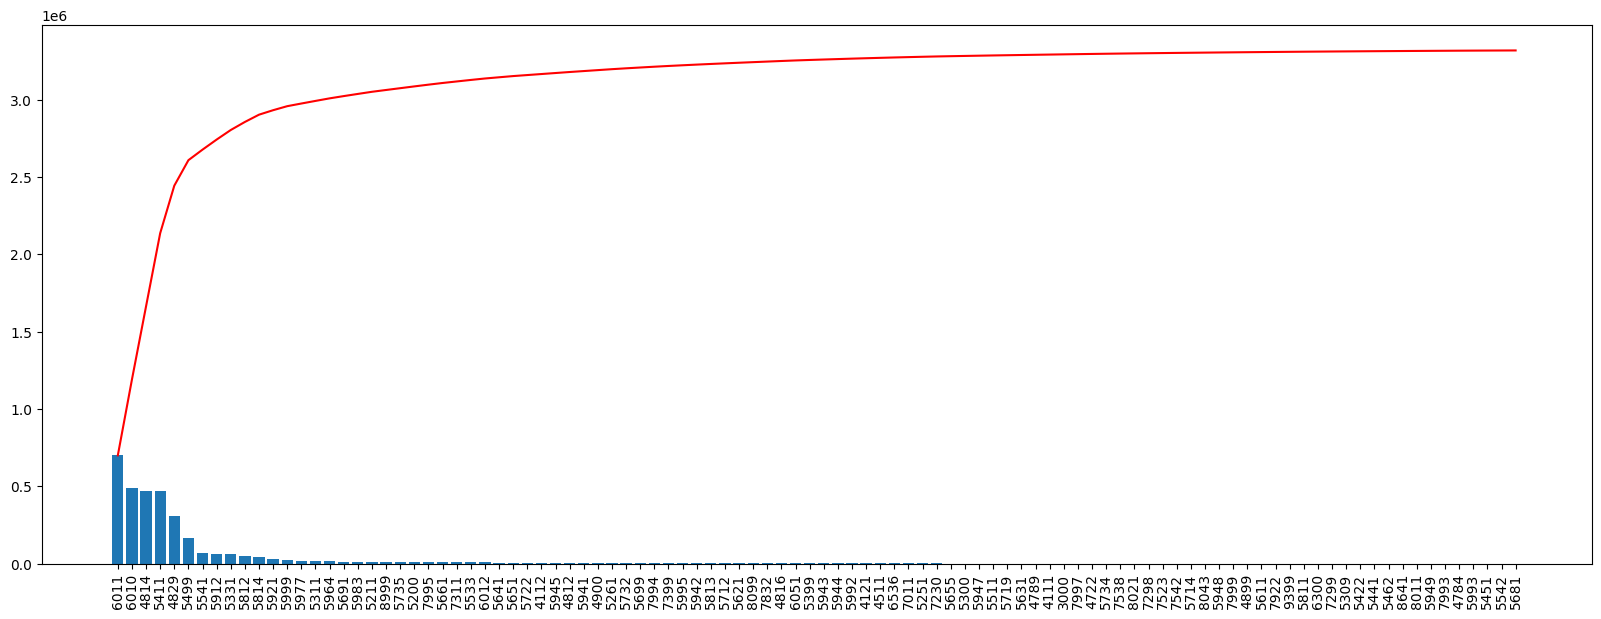

In [9]:
vc = df_train.Data.explode().value_counts()[:100]
xs = list(map(str, vc.index))
plt.plot(xs , vc.cumsum(), c='red')
plt.bar(xs, vc)
plt.xticks(rotation=90)
plt.show()

У нас есть 6 кодов, которые составляют 80% выборки. 
Возможно, все остальные вообще не имеет смысла предсказывать

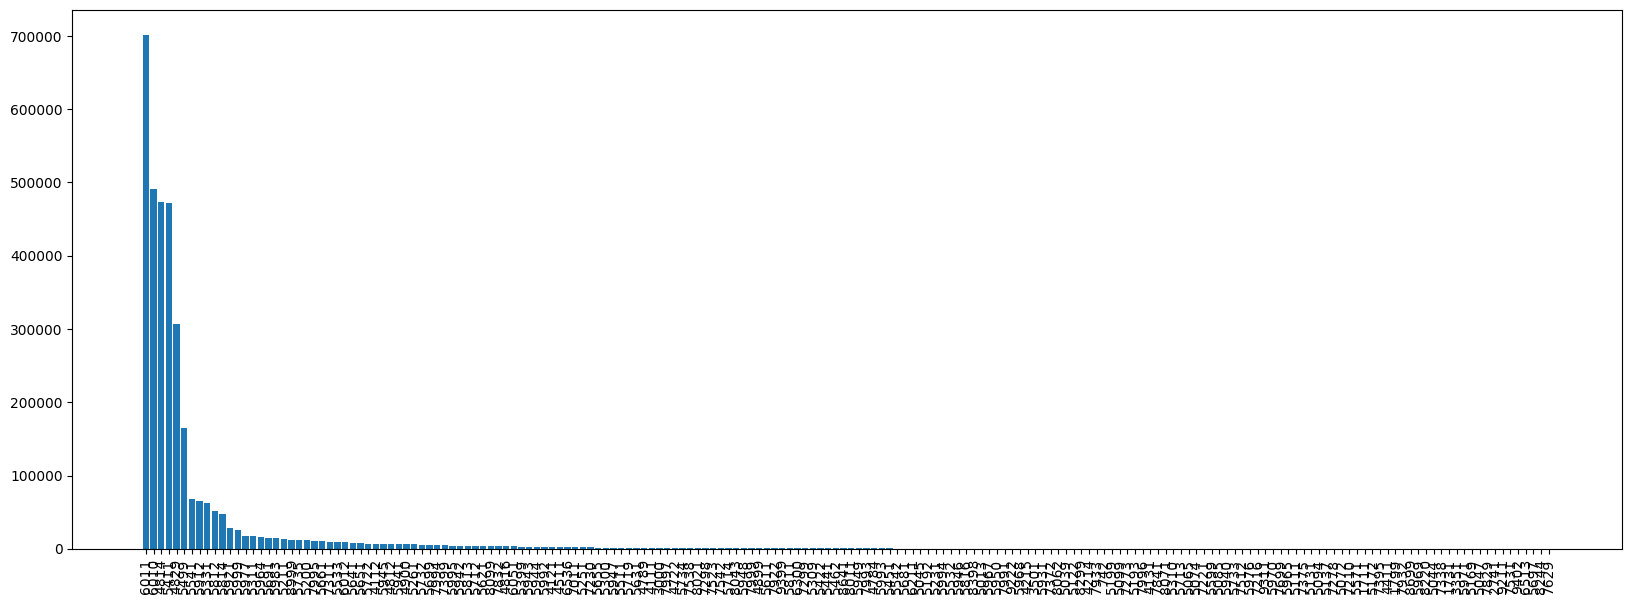

In [10]:
vc = df_train.Data.explode().value_counts()
plt.bar(list(map(str, vc.index)), vc)
plt.xticks(rotation=90)
plt.show()

In [30]:
df_train.Data.explode().value_counts().head(10)

6011    700677
6010    490602
4814    473396
5411    472408
4829    307388
5499    164719
5541     68224
5912     65071
5331     61833
5812     52029
Name: Data, dtype: int64

Самые популярные коды с описанием

In [12]:
# 6011    700677  Финансовые учреждения – снятие наличных автоматически
# 6010    490602  Финансовые учреждения – выдача наличных в кассе
# 4814    473396  Телекоммуникационные услуги
# 5411    472408  Бакалейные магазины, супермаркеты
# 4829    307388  Денежные переводы
# 5499    164719  Различные продовольственные магазины - нигде более не классифицированные
# 5541     68224  Заправочные станции (с вспомогательными услугами или без)
# 5912     65071  Аптеки
# 5331     61833  Универсальные магазины
# 5812     52029  Места общественного питания, рестораны

(array([ 780784.,       0.,       0.,       0.,  534241.,  164719.,
          68224.,       0.,   52029., 1256350.]),
 array([4814. , 4933.7, 5053.4, 5173.1, 5292.8, 5412.5, 5532.2, 5651.9,
        5771.6, 5891.3, 6011. ]),
 <BarContainer object of 10 artists>)

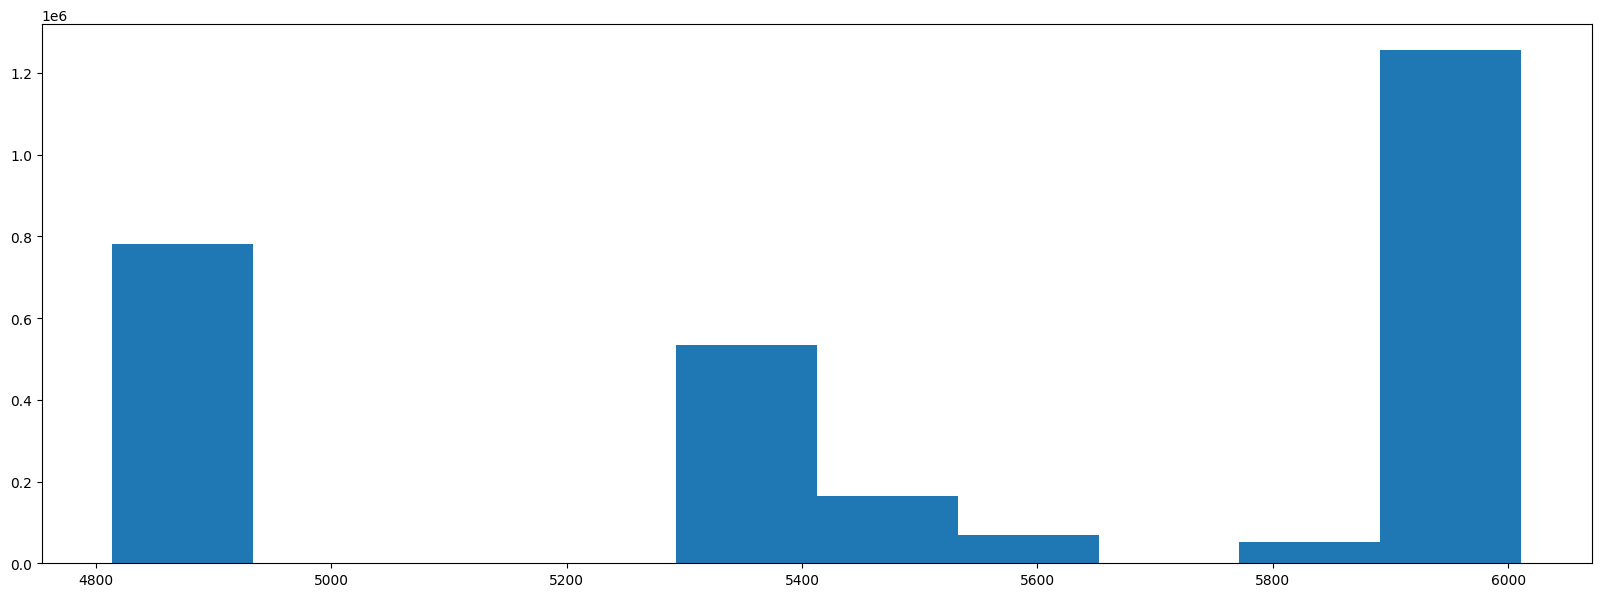

In [13]:
t = pd.Series(df_train.Data.explode())
top10 = df_train.Data.explode().value_counts().head(10).index
plt.hist(t[t.isin(top10)])

### Везде ли есть топ6 кодов?

Константно ли их распрдление внутри людей?

In [45]:
top6_codes = df_train.Data.explode().value_counts().head(6).index
top10_codes = df_train.Data.explode().value_counts().head(10).index
top6_codes

Int64Index([6011, 6010, 4814, 5411, 4829, 5499], dtype='int64')

### распредление кол-ва уникальных кодов

<AxesSubplot: >

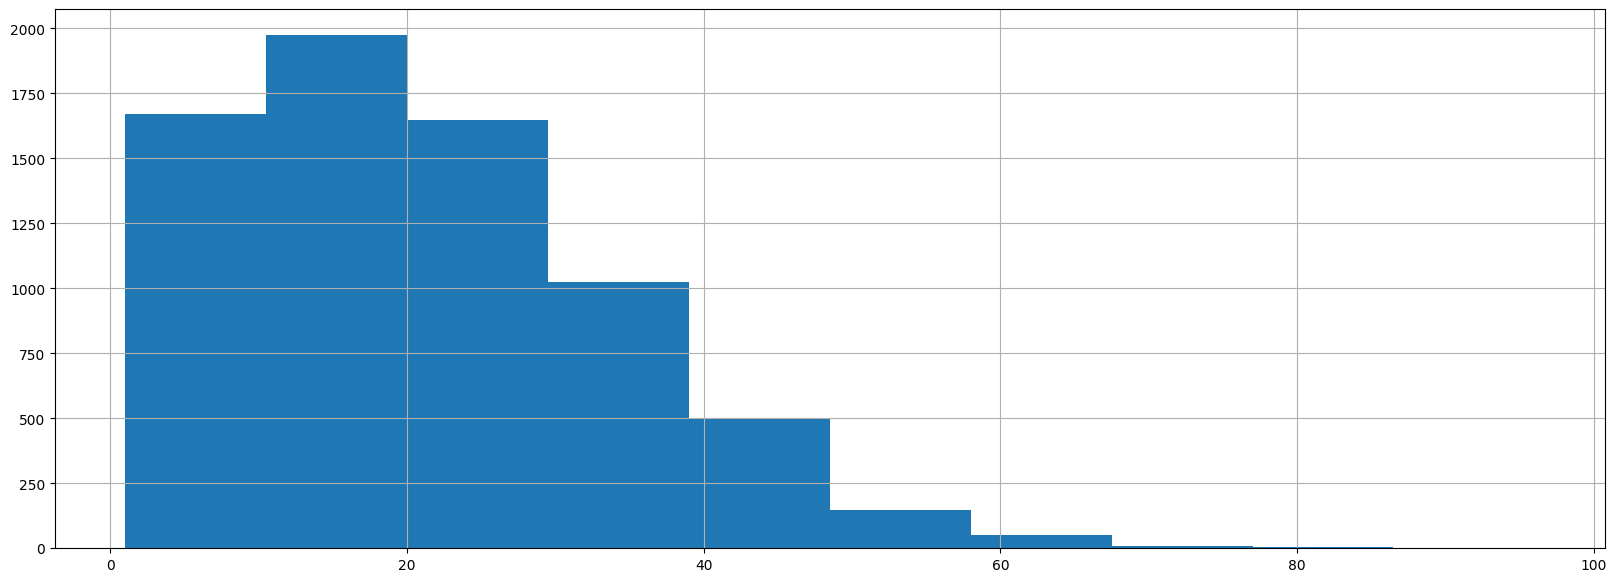

In [129]:
df_train.Data.map(set).map(len).hist()
# в среднем, 20-30 разных кодов есть у каждого человека

In [43]:
df_train.Data.map(set).map(lambda codes: all(top_code in codes for top_code in top6_codes)).value_counts()
# все 6 кодов есть только в половине людей

True     3926
False    3107
Name: Data, dtype: int64

In [48]:
df_train.Data.map(set).map(lambda codes: sum(top_code in codes for top_code in top10_codes)).value_counts()


9     1481
10    1427
8     1223
7      932
6      702
5      511
4      415
3      200
2      119
1       23
Name: Data, dtype: int64

In [14]:
df_train.Target

0       [4814, 4814, 4814, 4814, 5411, 4814, 4814, 481...
1       [4814, 6011, 4814, 6011, 4814, 4814, 6011, 481...
2       [6011, 6011, 6010, 4829, 4829, 6010, 6011, 601...
3       [6011, 6011, 6010, 6011, 6011, 4814, 4814, 601...
4       [5499, 6011, 4814, 4829, 5200, 5411, 5499, 591...
                              ...                        
7028    [4814, 5499, 5499, 5411, 5251, 4814, 5499, 549...
7029    [6011, 5261, 6011, 5261, 4814, 5411, 4814, 601...
7030    [6011, 6011, 6011, 6011, 6011, 6011, 6011, 601...
7031    [4814, 6011, 6011, 5999, 5999, 6011, 6011, 601...
7032    [6011, 4829, 6010, 6011, 6011, 5411, 6011, 554...
Name: Target, Length: 7033, dtype: object

In [15]:
len(df_train.Target[0])

10

In [16]:
df_train.shape

(7033, 3)

In [17]:
df_train.dtypes

Id         int64
Data      object
Target    object
dtype: object

In [18]:
df_test.head()

,Id,Data
0,0,"[4814, 4814, 6011, 6011, 6010, 6011, 6011, 481..."
1,1,"[6010, 6011, 6010, 5411, 5411, 5977, 6011, 601..."
2,2,"[4814, 6011, 5251, 6011, 7832, 5641, 5814, 482..."
3,3,"[6011, 4722, 4722, 4722, 4814, 6011, 6011, 482..."
4,4,"[4814, 4814, 4814, 6011, 4814, 4814, 4814, 481..."


In [19]:
df_test.shape

(7033, 2)

In [20]:
df_test.dtypes

Id       int64
Data    object
dtype: object

## Baseline 1: топ10 MCC-кодов из train-части

MCC-код и соответствующее количество вхождений в train-часть

In [49]:
# top10_codes = df_train['Data'].explode().value_counts().head(10)
# top10_codes

In [50]:
mapk(df_train['Target'], [df_train['Data'].explode().value_counts().head(10).index]*len(df_train))

0.2742435829727881

## Baseline 2: cамые популярные транзакции пользователя.

**Если таких менее 10, то замешиваются топ10 популярных из всей выборки.**

In [52]:
top_all = df_train.Data.explode().value_counts().index
# top_all

In [55]:
def get_top_codes(transactions, top_n=10, drop_from=5):
    transactions_stats = sorted(
        Counter(transactions).items(), 
        key=lambda x: x[1], 
        reverse=True
    )[:top_n]

    top_codes = [mcc_code for (mcc_code, count) in transactions_stats if count >= drop_from]
    if len(top_codes)==top_n:
        return top_codes
    
    i=0
    while len(top_codes)!=top_n:
        alt = top_all[i]
        if alt not in top_codes:
            top_codes.append(alt)
        i+=1

    return top_codes[:10]

In [56]:
df_train['pred_baseline_2'] = df_train['Data'].apply(get_top_codes)

In [134]:
# df_train['pred_baseline_2']

In [69]:
mapk(df_train['Target'], df_train['pred_baseline_2'])

0.32995672329313736

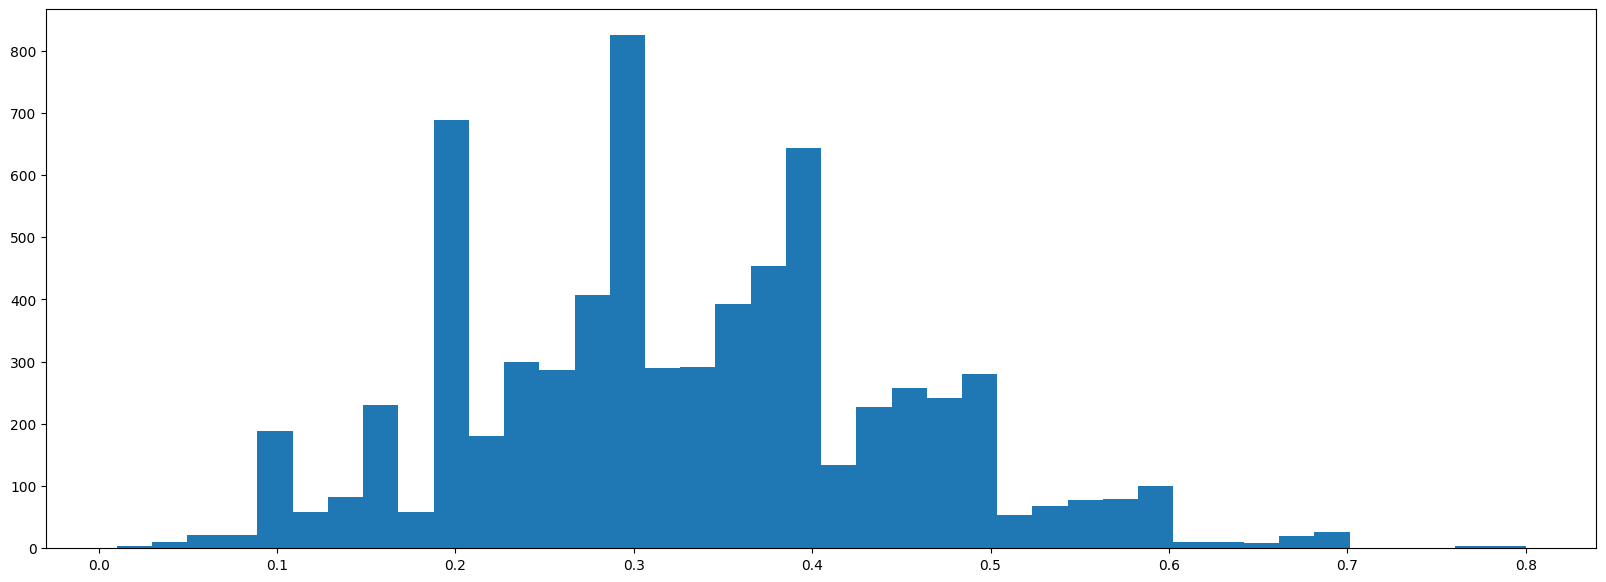

In [70]:
df_train_apks =pd.Series(apks(df_train['Target'], df_train['pred_baseline_2']), index = df_train.index)
plt.hist(df_train_apks, bins=40)
plt.show()
# распределение apk

мы предсказываем нерелевантные?
или мы предсказываем релевантные, но в конце?

In [97]:
main = df_train_apks[(df_train_apks<0.35) & (df_train_apks >0.3)]
tr = df_train.copy()
tr.Target = tr.Target.map(set)
tr.Data = tr.Data.map(lambda l: [x for x in sorted(
        Counter(l).items(), 
        key=lambda x: x[1], 
        reverse=True
    )])

d = tr.loc[main.index][["Data","Target",'pred_baseline_2']][2:3]
for x in d.columns:
    print(d[x].values)


[list([(6011, 145), (4814, 55), (5921, 54), (5541, 35), (5411, 18), (4829, 16), (5499, 13), (5812, 4), (6010, 3), (5983, 2), (5712, 2), (5261, 2), (7011, 2), (7933, 1), (5451, 1), (5722, 1), (5999, 1), (5542, 1), (5943, 1), (4816, 1), (5331, 1), (5814, 1), (5399, 1)])]
[{5921, 5411, 5541, 5399, 6011}]
[list([6011, 4814, 5921, 5541, 5411, 4829, 5499, 6010, 5912, 5331])]


In [124]:
df_train.Data.map(len).round(-1).value_counts()

160      158
60       154
140      149
200      141
120      140
        ... 
2560       1
1890       1
2370       1
15200      1
14730      1
Name: Data, Length: 249, dtype: int64

In [118]:
df_test.Data.map(len).round(-1).value_counts()

80      159
60      158
140     150
160     147
120     138
       ... 
5860      1
2250      1
4670      1
2340      1
4550      1
Name: Data, Length: 235, dtype: int64

In [132]:
df_train.Data.map(len).round(-1).quantile(0.8), df_test.Data.map(len).round(-1).quantile(0.5),

(640.0, 340.0)

Длина истории различна. 
Предположение: на большой исотрии мы соберем более правдивую статистику, которая будет больше похожа на тагрет из 10 значений.

Рассмотрим только людей с большой историей. (Квантили). Предскажем на них. Увеличится ли метрика?

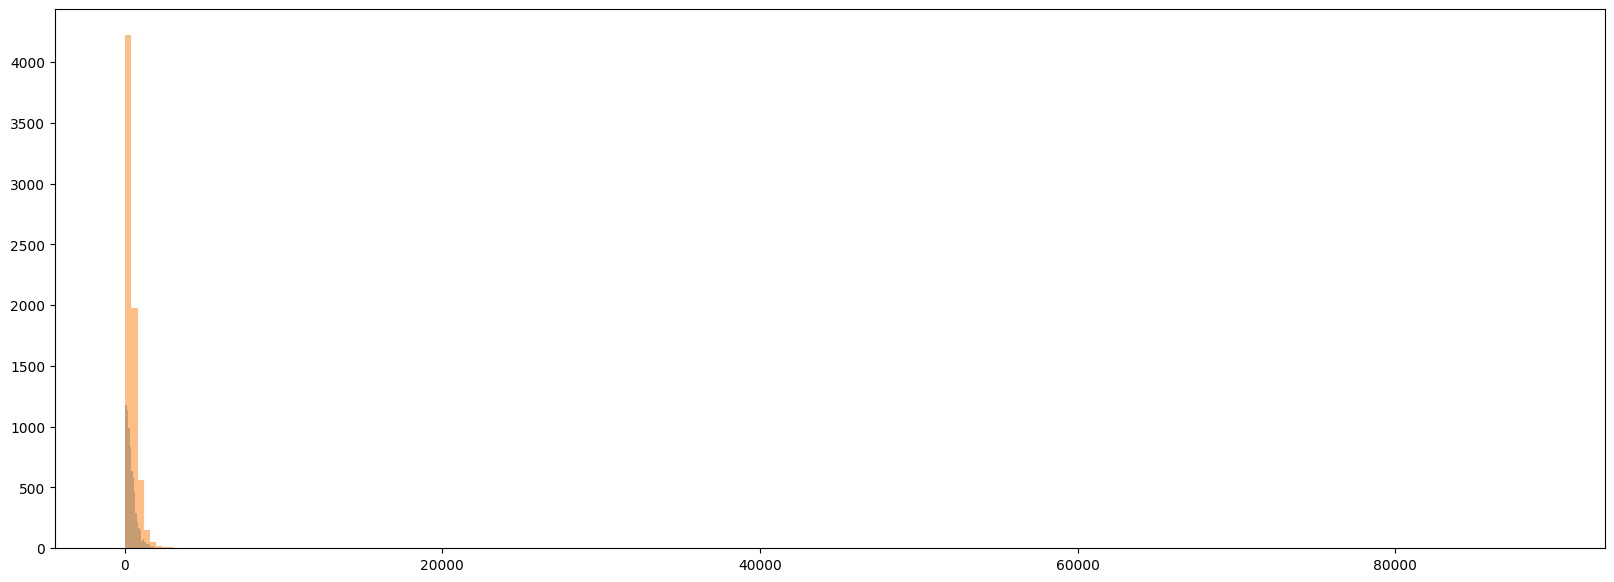

In [123]:
plt.hist(df_train.Data.map(len).round(-1), bins=230, alpha=0.5)
plt.hist(df_test.Data.map(len).round(-1), bins=230, alpha=0.5)
plt.show()
# распредление числа транзакций в истории

In [143]:
df_train.Data.map(len).round(-1).quantile(0.8)

640.0

In [144]:
df_train["Data_len"]=df_train.Data.map(len)
long_history = df_train[df_train.Data_len>640]
long_history['pred_baseline_2'] = long_history['Data'].apply(get_top_codes)

In [145]:
mapk(long_history.Target, long_history['pred_baseline_2'])

0.3583125458961758

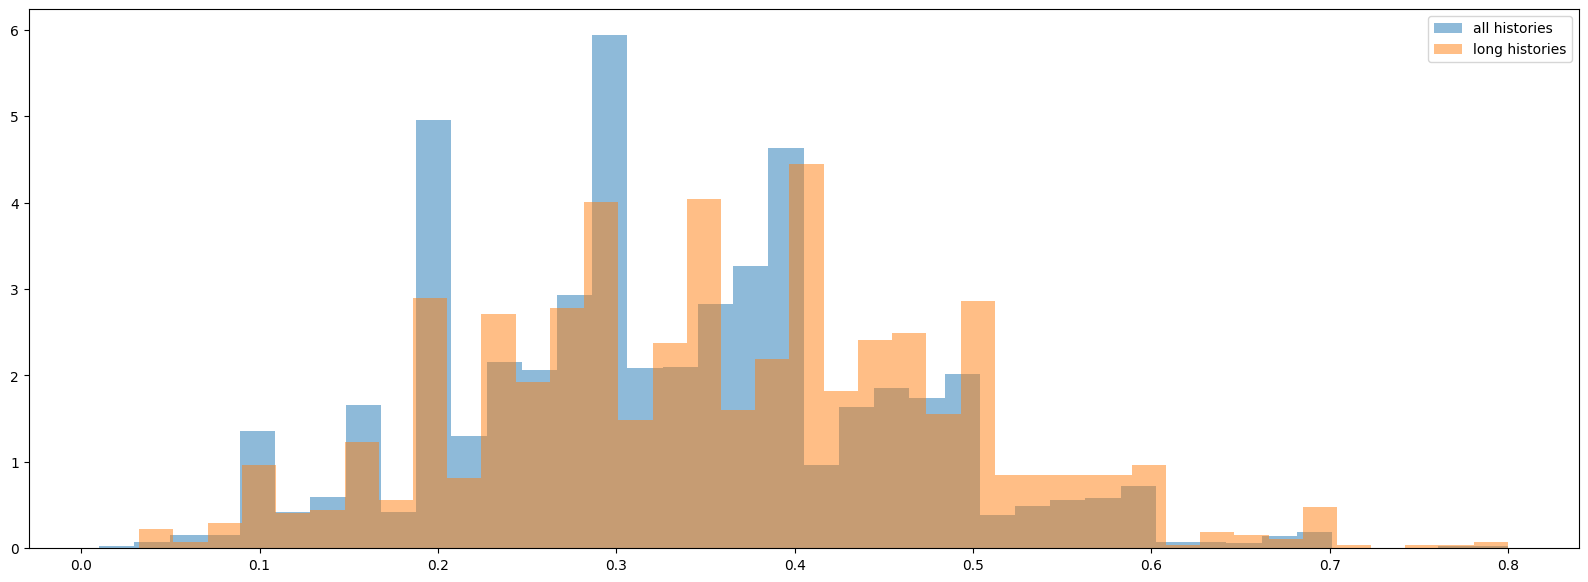

In [148]:
long_history_apks =pd.Series(apks(long_history.Target, long_history['pred_baseline_2']), index = long_history.index)
plt.hist(df_train_apks, bins=40, alpha = 0.5, density=True)
plt.hist(long_history_apks, bins=40, alpha = 0.5, density=True)
plt.legend(["all histories", "long histories"])
plt.show()
# распределение apk

In [154]:
main = long_history_apks[(long_history_apks.between(0.3, 0.35))]
tr = long_history.copy()
tr.Target = tr.Target.map(set)
tr.Data = tr.Data.map(lambda l: [x for x in sorted(
        Counter(l).items(), 
        key=lambda x: x[1], 
        reverse=True
    )])

d = tr.loc[main.index][["Data","Target",'pred_baseline_2']][2:3]
for x in d.columns:
    print(d[x].values)

[list([(4829, 304), (6011, 258), (4814, 176), (6010, 175), (4112, 43), (5411, 27), (5499, 21), (5912, 15), (7311, 15), (4900, 14), (4816, 12), (4899, 11), (6012, 10), (5311, 8), (5541, 8), (4511, 6), (5542, 5), (5533, 5), (9311, 5), (5983, 4), (5999, 4), (5661, 4), (4812, 4), (5192, 4), (5331, 3), (7538, 3), (7399, 3), (5814, 3), (4111, 3), (7999, 2), (7832, 2), (5921, 2), (8099, 2), (5945, 2), (5813, 2), (5699, 1), (5691, 1), (5941, 1), (5948, 1), (5732, 1), (5977, 1), (5734, 1), (5812, 1), (7299, 1), (3000, 1), (6300, 1), (7523, 1), (5942, 1), (5964, 1), (4214, 1)])]
[{5921, 5541, 4814, 5912, 6011, 5532, 4829}]
[list([4829, 6011, 4814, 6010, 4112, 5411, 5499, 5912, 7311, 4900])]


Как часто топ1 код встречается в тагрете?

In [158]:
for top_code in top10_codes:
    freq_target = df_train.Target.map(lambda l: top_code in l).mean()
    freq_data = df_train.Data.map(lambda l: top_code in l).mean()
    print(f"{top_code} {freq_data.round(2)} {freq_target.round(2)} ")

6011 1.0 0.82 
6010 0.88 0.39 
4814 0.97 0.68 
5411 0.9 0.57 
4829 0.82 0.39 
5499 0.69 0.24 
5541 0.49 0.14 
5912 0.74 0.16 
5331 0.58 0.11 
5812 0.5 0.08 


In [163]:
freqs = []
for top_code in set(df_train.Data.explode()):
    freq_target = df_train.Target.map(lambda l: top_code in l).mean()
    freq_data = df_train.Data.map(lambda l: top_code in l).mean()
    freqs.append((top_code, freq_data.round(2), freq_target.round(2)))
    # print(f"{top_code} {freq_data.round(2)} {freq_target.round(2)} ")

freqs = sorted(freqs, key = lambda t: (t[2], t[1]), reverse=True)
for t in freqs[:10]:
    print(t)

(6011, 1.0, 0.82)
(4814, 0.97, 0.68)
(5411, 0.9, 0.57)
(6010, 0.88, 0.39)
(4829, 0.82, 0.39)
(5499, 0.69, 0.24)
(5912, 0.74, 0.16)
(5541, 0.49, 0.14)
(5331, 0.58, 0.11)
(5812, 0.5, 0.08)


## Bootstrap
Для каждого пользователя бутстрапируем выборки размера 10 из истории. Считаем частоту каждого кода среди бутстрапированных выборок. То есть найдем что-то типа матожидания частоты каждого кода меленькой выборки

In [174]:
import numpy as np
top50_codes = top_all[:50]
def bootstrap(data,sample_size,  n_bootstrap_samples=1000):
    return [np.random.choice(data, size=sample_size, replace=True) for _ in range(n_bootstrap_samples)]

In [183]:
res = []
df_train_bs = df_train.copy()
for index, user in df_train_bs.iterrows():
    bootstraped_samples = bootstrap(user.Data, sample_size=10, n_bootstrap_samples=100)
    freq_by_code = []
    for top_code in top50_codes:
        f = np.mean([top_code in bs for bs in bootstraped_samples])
        freq_by_code.append((top_code, f))
    res.append([tc for (tc, f) in sorted(freq_by_code, key=lambda x:x[1], reverse=True)[:10]])

df_train_bs['predicted_bs'] = res
df_train_bs


,Id,Data,Target,pred_baseline_2,Data_len,predicted_bs
0,0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481...","[4814, 6011, 5311, 5411, 6010, 4829, 5499, 554...",216,"[4814, 6011, 5311, 5411, 5921, 6010, 4829, 549..."
1,1,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...","[4814, 6011, 4814, 6011, 4814, 4814, 6011, 481...","[4814, 6011, 6010, 5411, 4829, 5499, 5541, 591...",101,"[4814, 6011, 4829, 6010, 5732, 5541, 5411, 549..."
2,2,"[8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...","[6011, 6011, 6010, 4829, 4829, 6010, 6011, 601...","[5814, 6010, 4829, 6011, 4814, 5411, 5331, 599...",284,"[6010, 5814, 4829, 6011, 4814, 5331, 5411, 599..."
3,3,"[4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...","[6011, 6011, 6010, 6011, 6011, 4814, 4814, 601...","[5411, 4814, 6011, 6010, 6012, 5999, 4829, 549...",355,"[4814, 5411, 6011, 6012, 5999, 6010, 5499, 569..."
4,4,"[4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...","[5499, 6011, 4814, 4829, 5200, 5411, 5499, 591...","[4814, 5411, 6011, 4829, 5912, 5499, 6010, 520...",942,"[4814, 5411, 6011, 4829, 5912, 5499, 6010, 597..."
...,...,...,...,...,...,...
7028,7028,"[6010, 4829, 6011, 6011, 6011, 6010, 6011, 601...","[4814, 5499, 5499, 5411, 5251, 4814, 5499, 549...","[5251, 4814, 5499, 6011, 6010, 4829, 5411, 554...",664,"[4814, 6011, 5499, 4829, 6010, 5411, 5912, 521..."
7029,7029,"[4814, 5699, 5641, 5411, 6010, 6011, 4814, 601...","[6011, 5261, 6011, 5261, 4814, 5411, 4814, 601...","[6011, 4814, 5411, 5912, 6010, 5499, 4900, 581...",586,"[6011, 4814, 5411, 5912, 5499, 6010, 4900, 581..."
7030,7030,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 601...","[6011, 6011, 6011, 6011, 6011, 6011, 6011, 601...","[6011, 6010, 4814, 5411, 4829, 5499, 5541, 591...",53,"[6011, 6010, 5411, 5200, 5912, 4814, 4829, 549..."
7031,7031,"[4814, 4814, 5411, 6011, 6011, 4814, 4814, 481...","[4814, 6011, 6011, 5999, 5999, 6011, 6011, 601...","[6011, 5499, 4814, 5999, 6010, 5411, 4829, 554...",204,"[6011, 5499, 4814, 5999, 6010, 4829, 5942, 541..."


In [184]:
mapk(df_train_bs.Target, df_train_bs['predicted_bs'])

0.3300833824216449

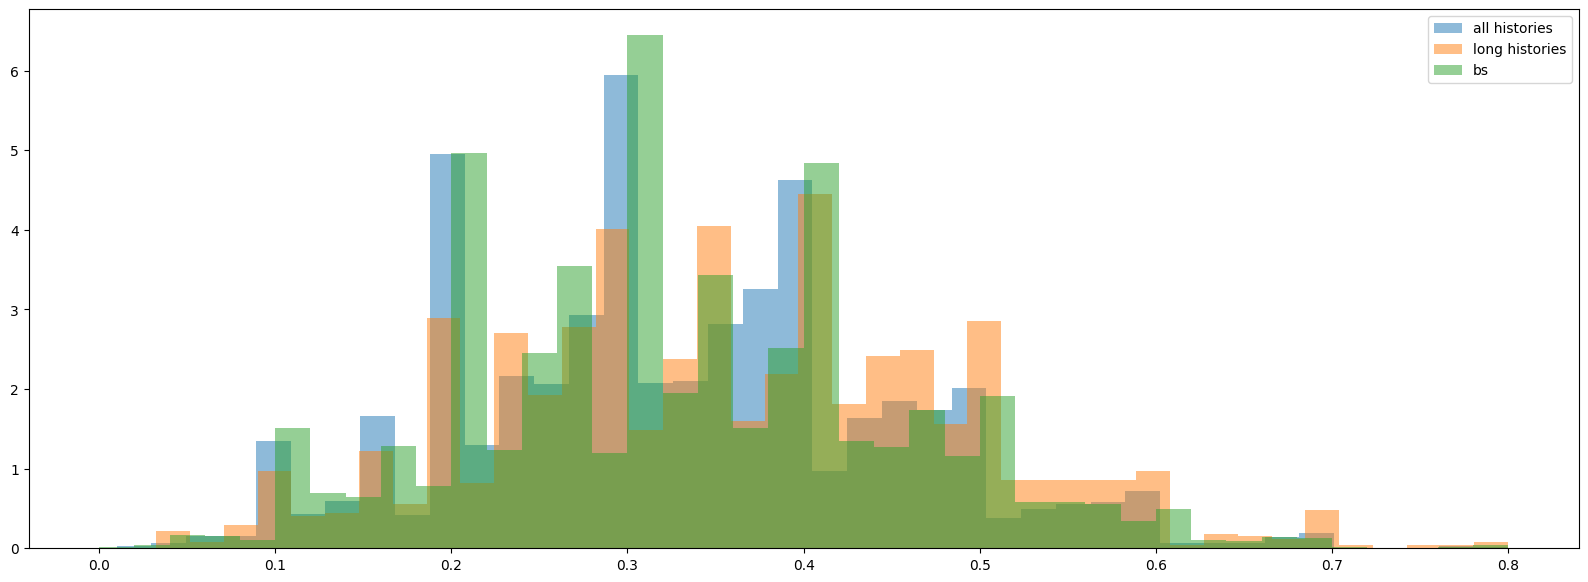

In [185]:
bs_apks =pd.Series(apks(df_train_bs.Target, df_train_bs['predicted_bs']), index = df_train_bs.index)
plt.hist(df_train_apks, bins=40, alpha = 0.5, density=True)
plt.hist(long_history_apks, bins=40, alpha = 0.5, density=True)
plt.hist(bs_apks, bins=40, alpha = 0.5, density=True)
plt.legend(["all histories", "long histories","bs"])
plt.show()
# распределение apk

## Submission

предсказания из второго бейзлайна

In [27]:
df_test['Predicted'] = df_test['Data'].apply(get_top_codes)

In [28]:
df_test.head()

,Id,Data,Predicted
0,0,"[4814, 4814, 6011, 6011, 6010, 6011, 6011, 481...","[6011, 4814, 6010, 4829, 5499, 5541, 5411, 601..."
1,1,"[6010, 6011, 6010, 5411, 5411, 5977, 6011, 601...","[6011, 6010, 5411, 6011, 6010, 4814, 5411, 482..."
2,2,"[4814, 6011, 5251, 6011, 7832, 5641, 5814, 482...","[6011, 6010, 5499, 4814, 5411, 5814, 4829, 581..."
3,3,"[6011, 4722, 4722, 4722, 4814, 6011, 6011, 482...","[6011, 4814, 5964, 5411, 4829, 5912, 6010, 601..."
4,4,"[4814, 4814, 4814, 6011, 4814, 4814, 4814, 481...","[4814, 6011, 6011, 6010, 4814, 5411, 4829, 549..."


In [29]:
submission_baseline_2 = df_test[['Id', 'Predicted']]
submission_baseline_2['Predicted'] = submission_baseline_2.Predicted.astype(str).str.replace(',', '')
submission_baseline_2.to_csv('submission_baseline_2.csv', index=False)